### Ensamble Learning?
- 여러 개의 분류기(Classifier)를 생성하고, 그 예측을 결합함으로써 더 정확한 예측을 도출하는 기법
- 다수 모델들을 결합하여 단일 모델을 보완
- 성능이 떨어지지만 서로 다른 유형의 모델들을 섞으면 오히려 성능이 향상되기도 함

### Voting and Bagging
- 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
- Voting : 서로 다른 알고리즘을 가진 분류기가 같은 데이터 셋을 기반으로 학습
- Bagging : 같은 알고리즘 유형의 모델들이지만 데이터 샘플링을 다르게 하여 학습 (단, 교차 검증과는 다르게 데이터 세트간의 중첩을 허용)

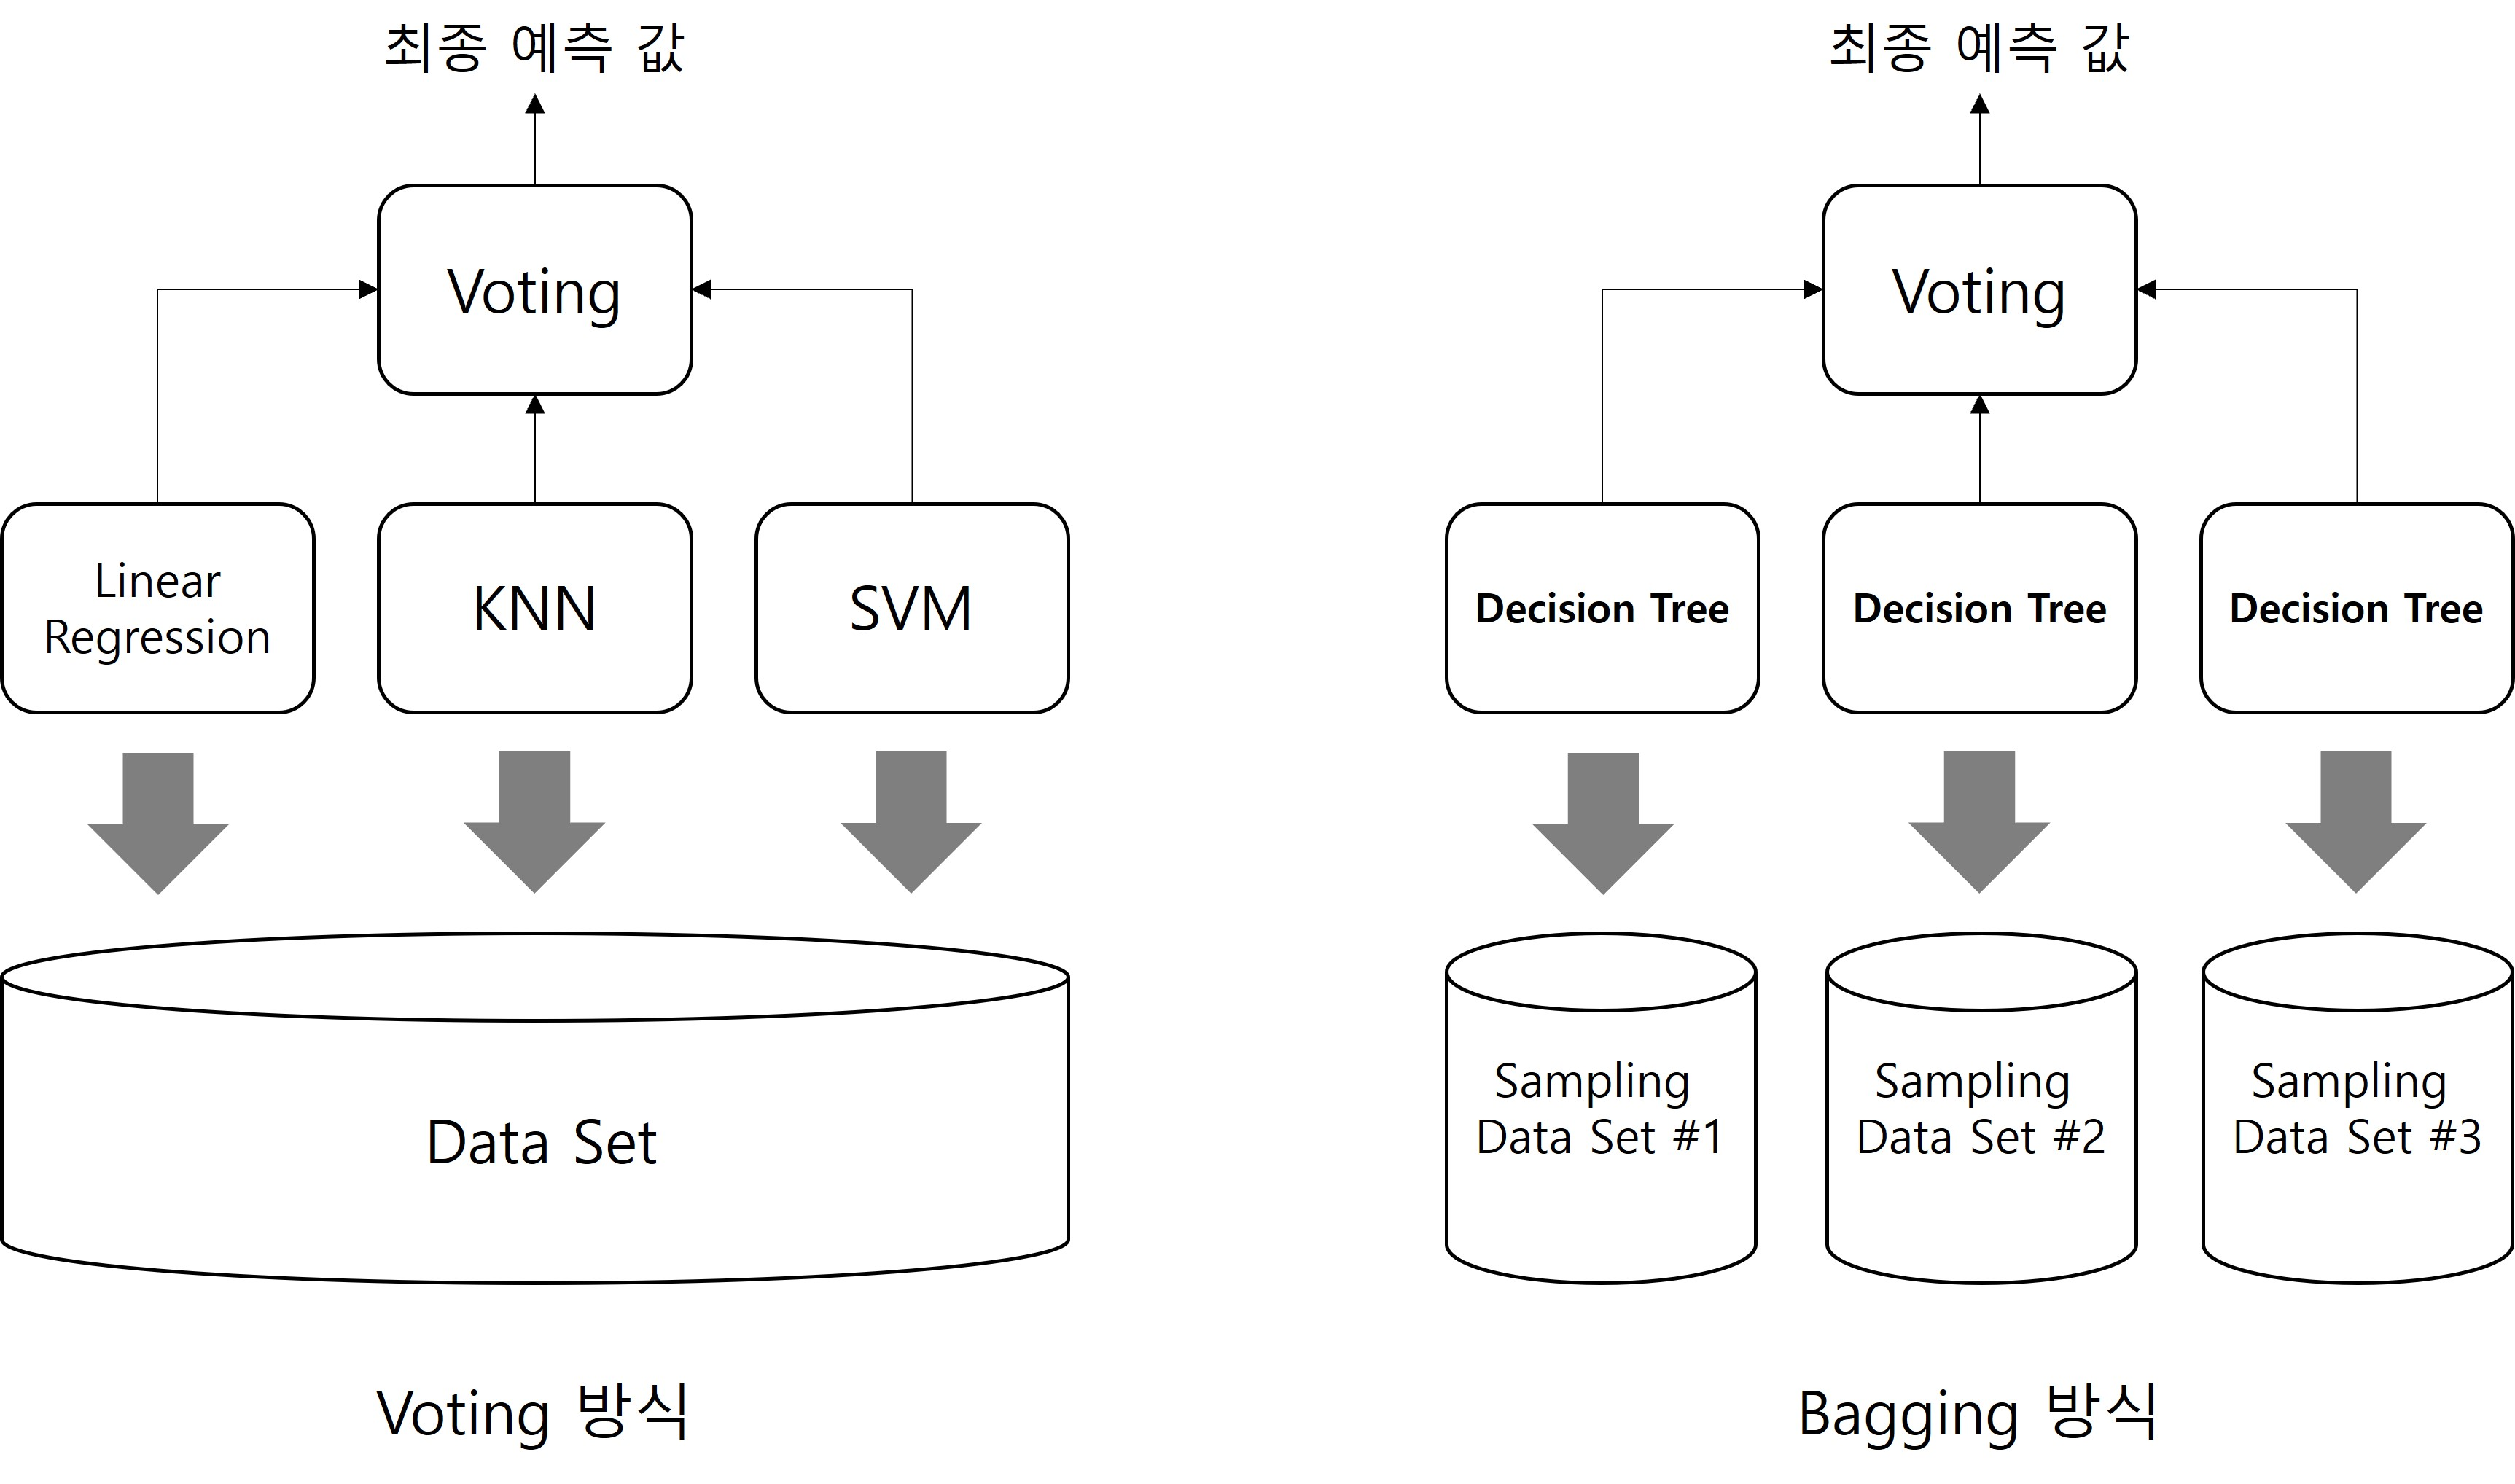

In [4]:
from IPython.display import Image
Image('voting_bagging.jpg', width = 500)

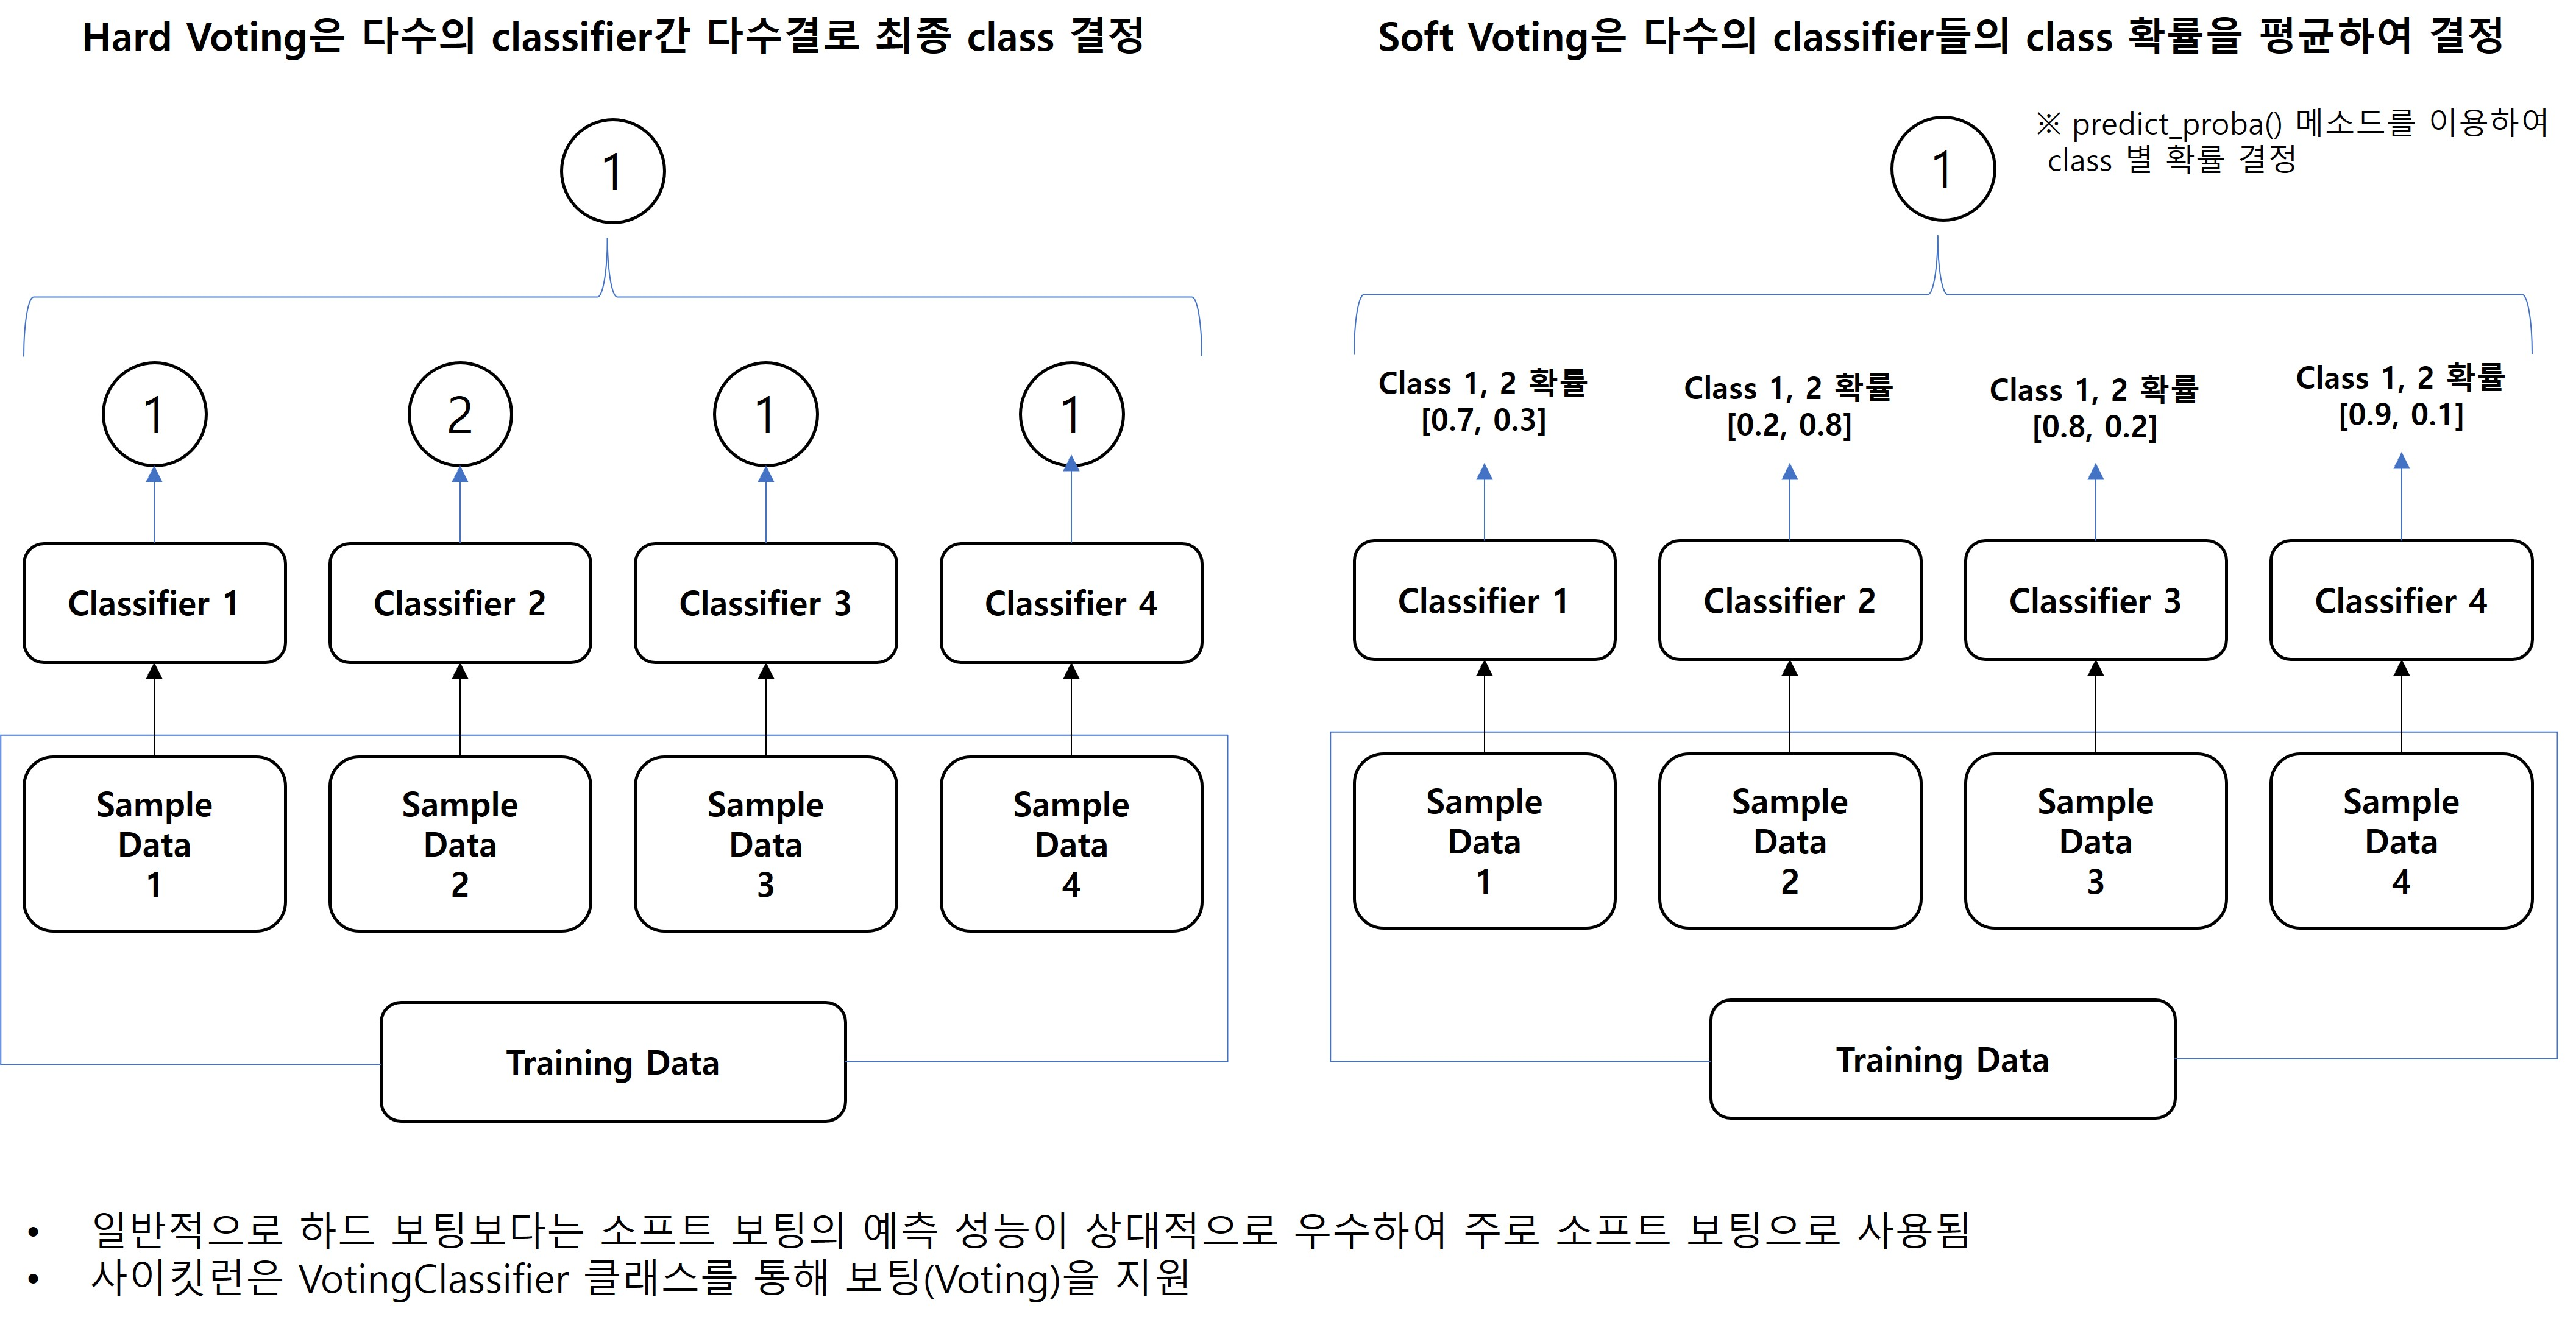

In [2]:
Image('voting2.jpg', width = 500)

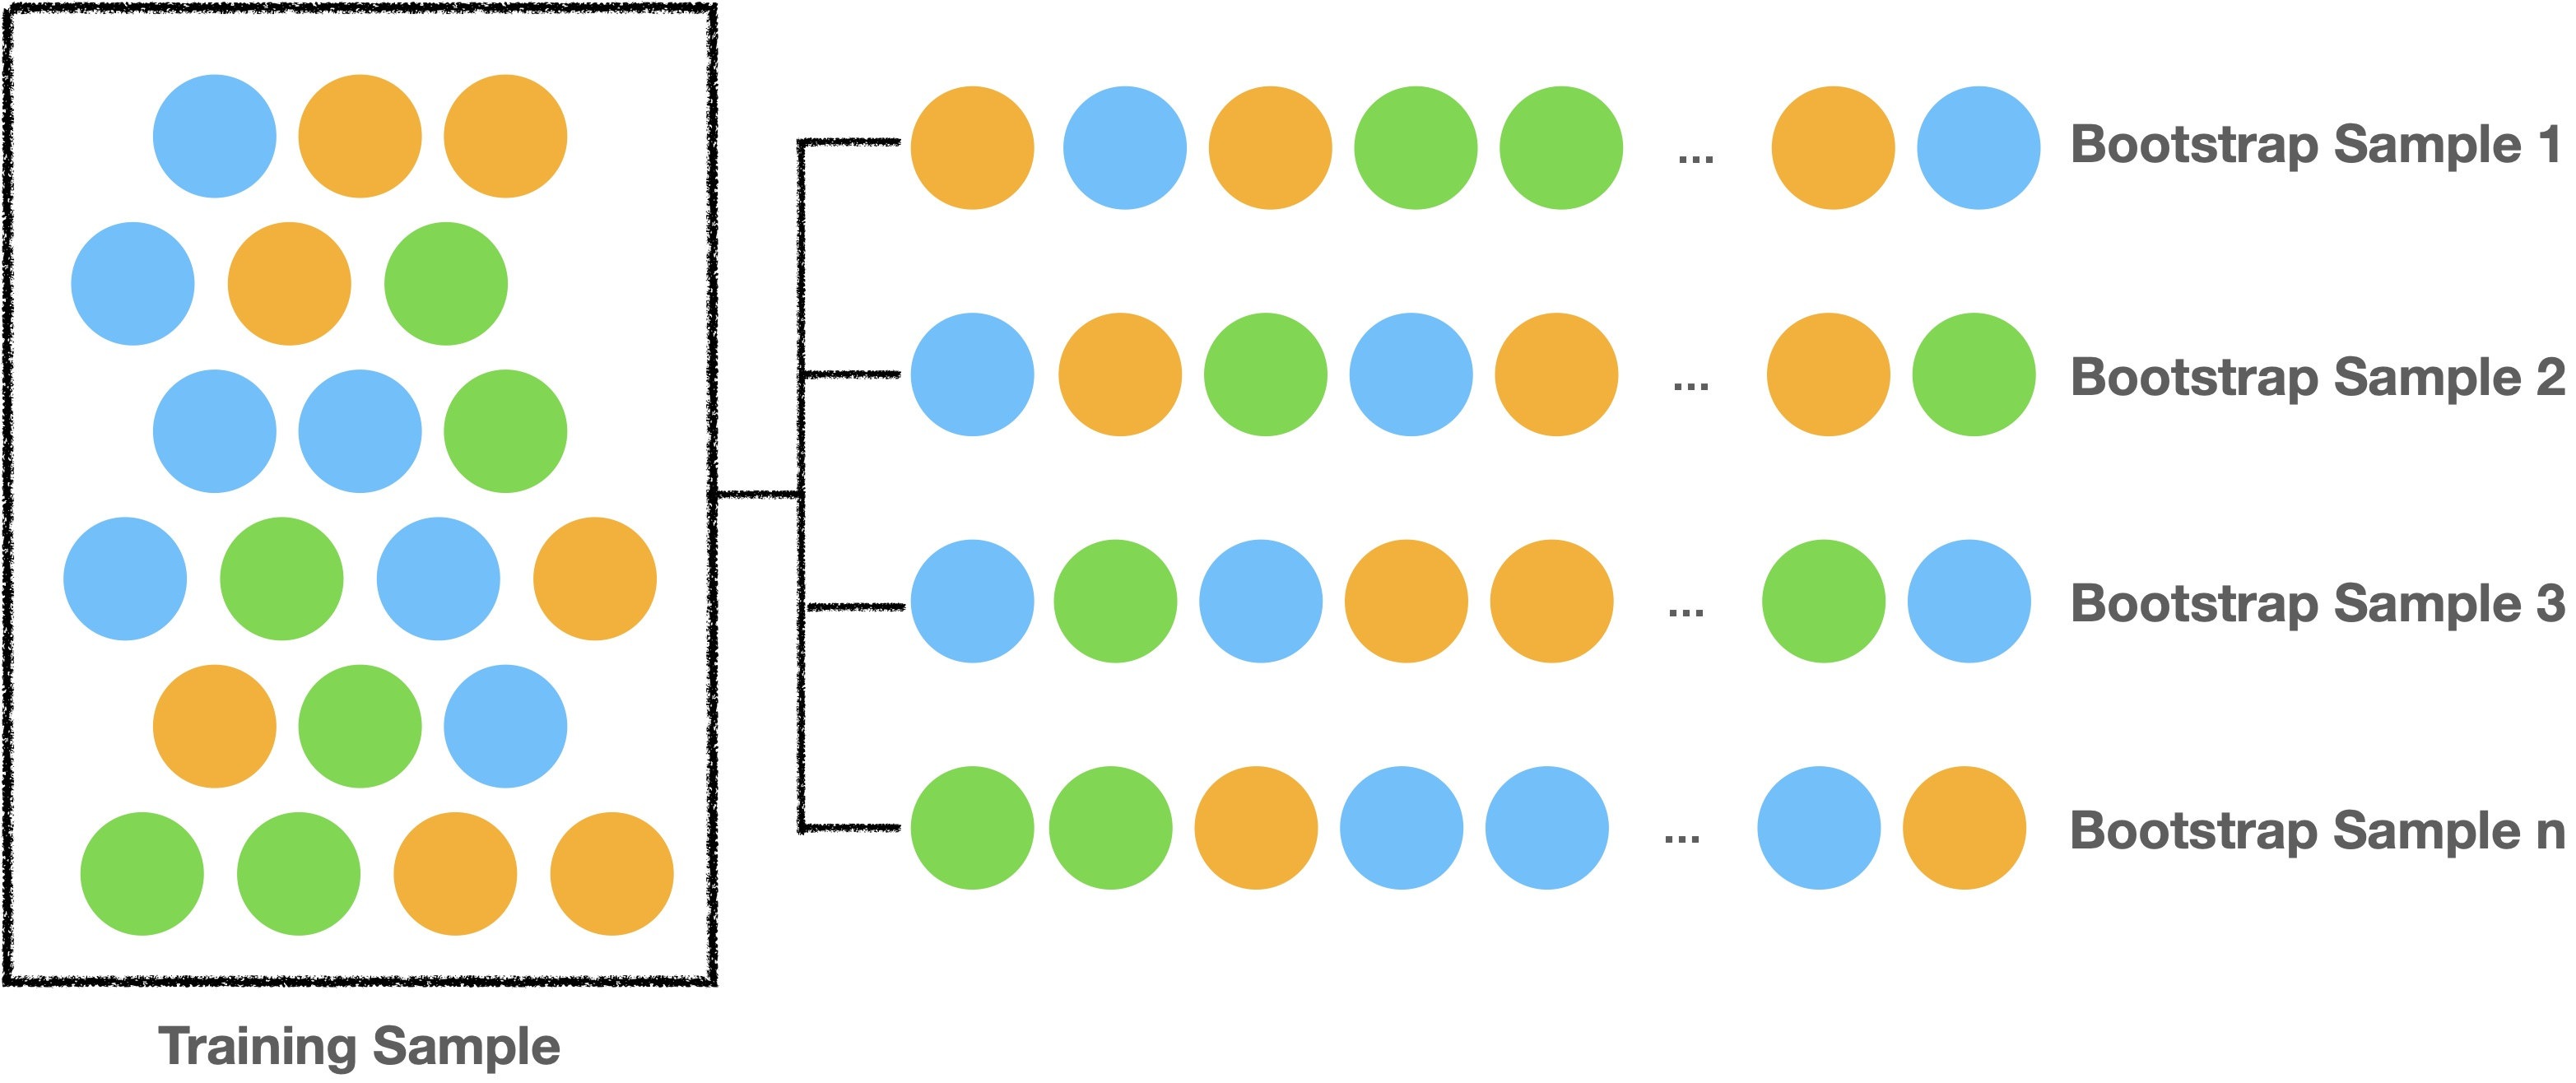

In [5]:
Image('bagging.jpg', width = 500)

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()

data = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data.head(3)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33            184.6   
1                 0.05667  ...         24.99          23.41            158.8   
2                 0.05999  ...         23.57          25.53            152.5   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  

[3 rows x 30 columns]

In [6]:
# 개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression(solver = 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors = 8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9561
LogisticRegression 정확도 : 0.9474
KNeighborsClassifier 정확도 : 0.9386


### Random Forest
- bagging을 사용하는 대표적인 알고리즘
- 같은 결정트리 classifier들이 샘플링 된 개별 데이터 서브세트를 학습한 뒤, 각각의 class에 대한 평균을 계산하여 최종 예측값을 도출

In [7]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    # cumcount()로 중복된 데이터 확인. 0인 경우 중복되지 않음
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    
    #중복된 데이터의 경우 column_name 뒤에 중복 카운트를 붙이고, 중복되지 않은 데이터는 그대로 삽입
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('../human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('../human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('../human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('../human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 사용해 train/test DataFrame return
X_train, X_test, y_train, y_test = get_human_dataset()

# random forest 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth = 8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Random Forest Accuracy : {0:.4f}'.format(accuracy))

Random Forest Accuracy : 0.9196


In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GirdSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y wa

최적 하이퍼 파라미터 : 
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 : 0.9165


In [11]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 6,
                                min_samples_split = 2, random_state = 0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9243


In [12]:
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_importances.sort_values(ascending=False)[:20]

angle(X,gravityMean)               0.036160
tGravityAcc-mean()-Y               0.033813
tGravityAcc-min()-X                0.030566
angle(Y,gravityMean)               0.028667
tGravityAcc-max()-X                0.026494
tGravityAcc-energy()-X             0.024100
tGravityAcc-min()-Y                0.024055
tGravityAcc-mean()-X               0.024040
tGravityAcc-max()-Y                0.021639
fBodyAccJerk-bandsEnergy()-1,8     0.018896
tGravityAcc-energy()-Y             0.015997
tBodyAcc-max()-X                   0.013816
tBodyAccJerk-entropy()-X           0.013485
tGravityAcc-max()-Z                0.013184
tGravityAcc-arCoeff()-Z,1          0.011376
tGravityAcc-energy()-Z             0.010811
fBodyAccMag-energy()               0.010693
tGravityAccMag-std()               0.009988
fBodyAcc-mad()-X                   0.009920
fBodyAccJerk-bandsEnergy()-1,16    0.009902
dtype: float64

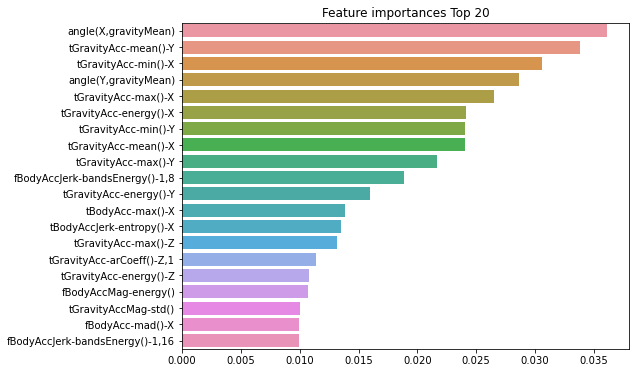

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()

### GBM(Gradient Boosting Machine)

- adaBoost 알고리즘에 경사하강법(Gradient Descent)을 적용하여 최적화된 결과를 얻는 알고리즘
- 예측 성능이 높지만 과적합 위험이 높고, 시간이 오래걸린다는 단점이 있음
- Greedy Algorithm : 미래를 생각하지 않고 각 단계에서 가장 최선의 선택을 하는 알고리즘

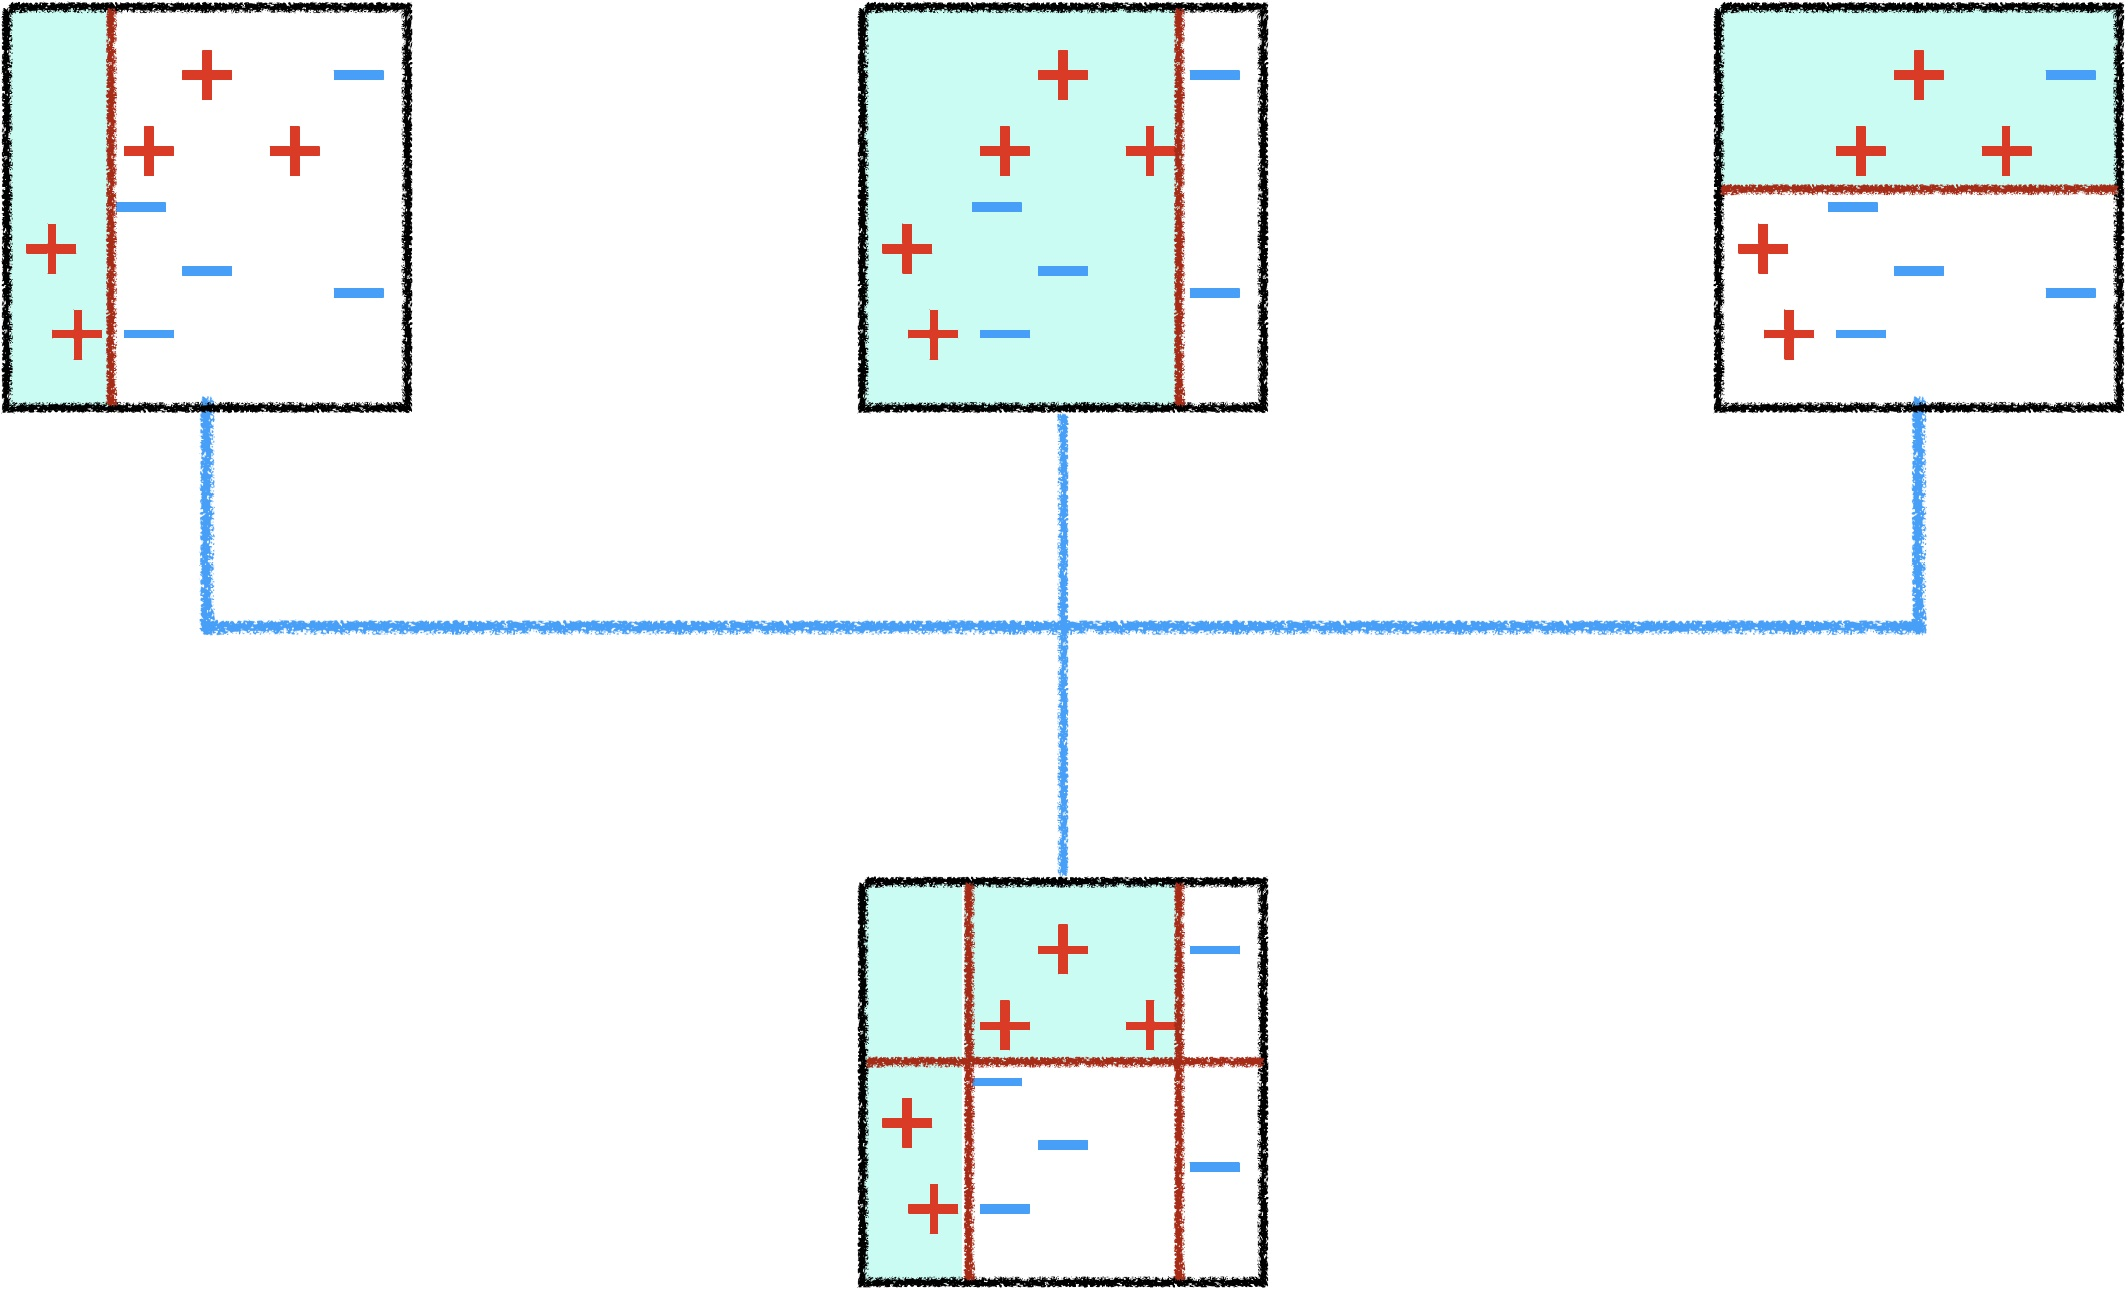

In [14]:
Image('gbm.jpg', width = 600)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간 : {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도 : 0.9393
GBM 수행 시간 : 539.8 초


In [ ]:
### 아래는 강의에서 설명드리지는 않지만 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 아래는 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다. 
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))